# 2016 US Bike Share Activity Snapshot

## Table of Contents
- [Introduction](#intro)
- [Posing Questions](#pose_questions)
- [Data Collection and Wrangling](#wrangling)
  - [Condensing the Trip Data](#condensing)
- [Exploratory Data Analysis](#eda)
  - [Statistics](#statistics)
  - [Visualizations](#visualizations)
- [Performing Your Own Analysis](#eda_continued)
- [Conclusions](#conclusions)

<a id='intro'></a>
## Introduction

Over the past decade, bicycle-sharing systems have been growing in number and popularity in cities across the world. Bicycle-sharing systems allow users to rent bicycles for short trips, typically 30 minutes or less. Thanks to the rise in information technologies, it is easy for a user of the system to access a dock within the system to unlock or return bicycles. These technologies also provide a wealth of data that can be used to explore how these bike-sharing systems are used.

The data is provided by [Motivate](https://www.motivateco.com/), a bike-share system provider for many major cities in the United States. We will compare the system usage between three large cities: New York City, Chicago, and Washington, DC. 

<a id='pose_questions'></a>
## Posing Questions

Before looking at the bike sharing data, you should start by asking questions you might want to understand about the bike share data. Consider, for example, if you were working for Motivate. What kinds of information would you want to know about in order to make smarter business decisions? If you were a user of the bike-share service, what factors might influence how you would want to use the service?

**Question 1**: Write at least two questions related to bike sharing that you think could be answered by data.

**Answer**:  
1) Is there any difference in the behaviour of users in different cities?   
2) What are the peak hours (maybe we can offer different rates for peak and off-peak hours)?  
3) What is the average ride duration in each city? (should we offer hourly or daily rates based on that?)

<a id='wrangling'></a>
## Data Collection and Wrangling

Now it's time to collect and explore our data. In this project, we will focus on the record of individual trips taken in 2016 from our selected cities: New York City, Chicago, and Washington, DC. Each of these cities has a page where we can freely download the trip data.:

- New York City (Citi Bike): [Link](https://www.citibikenyc.com/system-data)
- Chicago (Divvy): [Link](https://www.divvybikes.com/system-data)
- Washington, DC (Capital Bikeshare): [Link](https://www.capitalbikeshare.com/system-data)

A random 2% sample of the original data is taken to make the exploration more manageable. 

**Question 2**: The first trip recorded from each of the cities (the second line of each data file).

In [1]:
## import all necessary packages and functions.
import csv # read and write csv files
from datetime import datetime # operations to parse dates
from pprint import pprint # use to print data structures like dictionaries in
                          # a nicer way than the base print function.

In [2]:
def print_first_point(filename):
    """
    This function prints and returns the first data point (second row) from
    a csv file that includes a header row.
    """
    # print city name for reference
    city = filename.split('-')[0].split('/')[-1]
    print('\nCity: {}'.format(city))
    
    with open(filename, 'r') as f_in:
        ## TODO: Use the csv library to set up a DictReader object. ##
        ## see https://docs.python.org/3/library/csv.html           ##
        trip_reader = csv.DictReader(f_in)
        
        ## TODO: Use a function on the DictReader object to read the     ##
        ## first trip from the data file and store it in a variable.     ##
        ## see https://docs.python.org/3/library/csv.html#reader-objects ##
        first_trip = next(trip_reader)
        
        ## TODO: Use the pprint library to print the first trip. ##
        ## see https://docs.python.org/3/library/pprint.html     ##
        pprint(first_trip)
    # output city name and first trip for later testing
    return (city, first_trip)

# list of files for each city
data_files = ['./data/NYC-CitiBike-2016.csv',
              './data/Chicago-Divvy-2016.csv',
              './data/Washington-CapitalBikeshare-2016.csv',]

# print the first trip from each file, store in dictionary
example_trips = {}
for data_file in data_files:
    city, first_trip = print_first_point(data_file)
    example_trips[city] = first_trip


City: NYC
OrderedDict([('tripduration', '839'),
             ('starttime', '1/1/2016 00:09:55'),
             ('stoptime', '1/1/2016 00:23:54'),
             ('start station id', '532'),
             ('start station name', 'S 5 Pl & S 4 St'),
             ('start station latitude', '40.710451'),
             ('start station longitude', '-73.960876'),
             ('end station id', '401'),
             ('end station name', 'Allen St & Rivington St'),
             ('end station latitude', '40.72019576'),
             ('end station longitude', '-73.98997825'),
             ('bikeid', '17109'),
             ('usertype', 'Customer'),
             ('birth year', ''),
             ('gender', '0')])

City: Chicago
OrderedDict([('trip_id', '9080545'),
             ('starttime', '3/31/2016 23:30'),
             ('stoptime', '3/31/2016 23:46'),
             ('bikeid', '2295'),
             ('tripduration', '926'),
             ('from_station_id', '156'),
             ('from_station_name', 'Clar

<a id='condensing'></a>
### Condensing the Trip Data

It should also be observable from the above printout that each city provides different information. Even where the information is the same, the column names and formats are sometimes different. To make things as simple as possible when we get to the actual exploration, we should trim and clean the data. Cleaning the data makes sure that the data formats across the cities are consistent, while trimming focuses only on the parts of the data we are most interested in to make the exploration easier to work with.

We will generate new data files with five values of interest for each trip: trip duration, starting month, starting hour, day of the week, and user type. Each of these may require additional wrangling depending on the city:

- **Duration**: This has been given to us in seconds (New York, Chicago) or milliseconds (Washington). A more natural unit of analysis will be if all the trip durations are given in terms of minutes.
- **Month**, **Hour**, **Day of Week**: Ridership volume is likely to change based on the season, time of day, and whether it is a weekday or weekend. Use the start time of the trip to obtain these values. The New York City data includes the seconds in their timestamps, while Washington and Chicago do not. The [`datetime`](https://docs.python.org/3/library/datetime.html) package will be very useful here to make the needed conversions.
- **User Type**: It is possible that users who are subscribed to a bike-share system will have different patterns of use compared to users who only have temporary passes. Washington divides its users into two types: 'Registered' for users with annual, monthly, and other longer-term subscriptions, and 'Casual', for users with 24-hour, 3-day, and other short-term passes. The New York and Chicago data uses 'Subscriber' and 'Customer' for these groups, respectively. For consistency, you will convert the Washington labels to match the other two.


**Question 3a**: Complete the helper functions in the code cells below to address each of the cleaning tasks described above.

In [3]:
def duration_in_mins(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the trip duration in units of minutes.
    
    Remember that Washington is in terms of milliseconds while Chicago and NYC
    are in terms of seconds. 
    
    HINT: The csv module reads in all of the data as strings, including numeric
    values. You will need a function to convert the strings into an appropriate
    numeric type when making your transformations.
    see https://docs.python.org/3/library/functions.html
    """
    
    # YOUR CODE HERE
    if city == "Washington":
        duration = int(datum['Duration (ms)'])/60000
    else: 
        duration = int(datum['tripduration'])/60
        
    return duration


# Some tests to check that your code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# you printed the first trip from each of the original data files.
tests = {'NYC': 13.9833,
         'Chicago': 15.4333,
         'Washington': 7.1231}

for city in tests:
    assert abs(duration_in_mins(example_trips[city], city) - tests[city]) < .001

In [4]:
def time_of_trip(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the month, hour, and day of the week in
    which the trip was made.
    
    Remember that NYC includes seconds, while Washington and Chicago do not.
    
    HINT: You should use the datetime module to parse the original date
    strings into a format that is useful for extracting the desired information.
    see https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
    """
    
    # YOUR CODE HERE
    if city == "Washington":
        date = datetime.strptime(datum['Start date'], '%m/%d/%Y %H:%M')
    elif city == "NYC":
        date = datetime.strptime(datum['starttime'], '%m/%d/%Y %H:%M:%S')
    else:
        date = datetime.strptime(datum['starttime'], '%m/%d/%Y %H:%M')
    return (date.month, date.hour, date.strftime("%A"))


# Some tests to check that your code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# you printed the first trip from each of the original data files.
tests = {'NYC': (1, 0, 'Friday'),
         'Chicago': (3, 23, 'Thursday'),
         'Washington': (3, 22, 'Thursday')}

for city in tests:    
    assert time_of_trip(example_trips[city], city) == tests[city]

In [5]:
def type_of_user(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the type of system user that made the
    trip.
    
    Remember that Washington has different category names compared to Chicago
    and NYC. 
    """
    
    # YOUR CODE HERE
    if city == "Washington":
        if datum["Member Type"] == "Registered":
            user_type = "Subscriber"
        else:
            user_type = "Customer"
    else:
        user_type = datum["usertype"]
    return user_type


# Some tests to check that your code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# you printed the first trip from each of the original data files.
tests = {'NYC': 'Customer',
         'Chicago': 'Subscriber',
         'Washington': 'Subscriber'}

for city in tests:
    assert type_of_user(example_trips[city], city) == tests[city]

**Question 3b**: Create condensed data file for each city consisting only of the data fields indicated above. 

In [7]:
def condense_data(in_file, out_file, city):
    """
    This function takes full data from the specified input file
    and writes the condensed data to a specified output file. The city
    argument determines how the input file will be parsed.
    
    HINT: See the cell below to see how the arguments are structured!
    """
    
    with open(out_file, 'w') as f_out, open(in_file, 'r') as f_in:
        # set up csv DictWriter object - writer requires column names for the
        # first row as the "fieldnames" argument
        out_colnames = ['duration', 'month', 'hour', 'day_of_week', 'user_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        ## TODO: set up csv DictReader object ##
        trip_reader = csv.DictReader(f_in)

        # collect data from and process each row
        for row in trip_reader:
            # set up a dictionary to hold the values for the cleaned and trimmed
            # data point
            new_point = {}

            ## TODO: use the helper functions to get the cleaned data from  ##
            ## the original data dictionaries.                              ##
            ## Note that the keys for the new_point dictionary should match ##
            ## the column names set in the DictWriter object above.         ##
            new_point['duration'] = duration_in_mins(row, city)
            month, hour, day_of_week = time_of_trip(row, city)
            new_point['month'] = month
            new_point['hour'] = hour
            new_point['day_of_week'] = day_of_week
            new_point['user_type'] = type_of_user(row, city)
            ## TODO: write the processed information to the output file.     ##
            ## see https://docs.python.org/3/library/csv.html#writer-objects ##
            trip_writer.writerow(new_point)            

In [8]:
# Run this cell to check your work
city_info = {'Washington': {'in_file': './data/Washington-CapitalBikeshare-2016.csv',
                            'out_file': './data/Washington-2016-Summary.csv'},
             'Chicago': {'in_file': './data/Chicago-Divvy-2016.csv',
                         'out_file': './data/Chicago-2016-Summary.csv'},
             'NYC': {'in_file': './data/NYC-CitiBike-2016.csv',
                     'out_file': './data/NYC-2016-Summary.csv'}}

for city, filenames in city_info.items():
    condense_data(filenames['in_file'], filenames['out_file'], city)
    print_first_point(filenames['out_file'])


City: Washington
OrderedDict([('duration', '7.123116666666666'),
             ('month', '3'),
             ('hour', '22'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: Chicago
OrderedDict([('duration', '15.433333333333334'),
             ('month', '3'),
             ('hour', '23'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: NYC
OrderedDict([('duration', '13.983333333333333'),
             ('month', '1'),
             ('hour', '0'),
             ('day_of_week', 'Friday'),
             ('user_type', 'Customer')])


<a id='eda'></a>
## Exploratory Data Analysis

<a id='statistics'></a>
### Statistics

First, let's compute some basic counts. The first cell below contains a function that uses the csv module to iterate through a provided data file, returning the number of trips made by subscribers and customers. The second cell runs this function on the example Bay Area data in the `/examples/` folder. Modify the cells to answer the question below.

**Question 4a**: Which city has the highest number of trips? Which city has the highest proportion of trips made by subscribers? Which city has the highest proportion of trips made by short-term customers?

**Answer**: City with the highest number of trips and city with the proportion of trips by subscribers is NYC. City with the highest proportion of trips by short-term customers is Chicago. 

In [9]:
def number_of_trips(filename):
    """
    This function reads in a file with trip data and reports the number of
    trips made by subscribers, customers, and total overall.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        n_subscribers = 0
        n_customers = 0
        
        # tally up ride types
        for row in reader:
            if row['user_type'] == 'Subscriber':
                n_subscribers += 1
            else:
                n_customers += 1
        
        # compute total number of rides
        n_total = n_subscribers + n_customers
        
        # return tallies as a tuple
        return(n_subscribers/n_total, n_customers/n_total, n_total)

In [10]:
## Modify this and the previous cell to answer Question 4a. Remember to run ##
## the function on the cleaned data files you created from Question 3.      ##
cities_stats = {}
for city in city_info:
    cities_stats[city] = number_of_trips(city_info[city]['out_file'])
    
#data_file = './examples/BayArea-Y3-Summary.csv'
#print(number_of_trips(data_file))

In [11]:
def find_max_by_dimension(data_points, dimension):
    """
    Finds the data point, that has the maximum value 
    in the given dimension. 
        data_points: list of tuples
        dimension: int (0-N)
    
    Returns the name of the city with the max dimension
    """
    current_max = 0
    current_best_city = ""
    for point in data_points:
        value = data_points[point][dimension]
        if value > current_max:
            current_max = value
            current_best_city = point
    return current_best_city

In [12]:
print("The city with the highest number of trips is {}.".format(find_max_by_dimension(cities_stats, 2)))
print("The city with the highest proportion of trips made by subscribers is {}."
      .format(find_max_by_dimension(cities_stats, 0)))
print("The city with the highest proportion of trips made by customers is {}."
      .format(find_max_by_dimension(cities_stats, 1)))

The city with the highest number of trips is NYC.
The city with the highest proportion of trips made by subscribers is NYC.
The city with the highest proportion of trips made by customers is Chicago.


**Question 4b**: Bike-share systems are designed for riders to take short trips. Most of the time, users are allowed to take trips of 30 minutes or less with no additional charges, with overage charges made for trips of longer than that duration. What is the average trip length for each city? What proportion of rides made in each city are longer than 30 minutes?

**Answer**:
<table>
    <tr>
    <th>City</th>
    <th>Average duartion</th> 
    <th>Trips over 30 mins</th>
  </tr>
  <tr>
    <td>Washington</td>
    <td>19</td> 
    <td>10.8%</td>
  </tr>
  <tr>
    <td>Chicago</td>
    <td>17</td> 
    <td>8.3%</td>
  </tr>
  <tr>
    <td>NYC</td>
    <td>16</td> 
    <td>7.3%</td>
  </tr>
 </table>

In [13]:
## Use this and additional cells to answer Question 4b.                 ##
##                                                                      ##
## HINT: The csv module reads in all of the data as strings, including  ##
## numeric values. You will need a function to convert the strings      ##
## into an appropriate numeric type before you aggregate data.          ##
## TIP: For the Bay Area example, the average trip length is 14 minutes ##
## and 3.5% of trips are longer than 30 minutes.                        ##
def average_trip_legnth(filename):
    """
    This function reads in a file with trip data and reports the number of
    trips made by subscribers, customers, and total overall.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        trip_lengths = 0
        n_trips = 0
        
        # tally up ride types
        for row in reader:
            trip_lengths += float(row['duration'])
            n_trips += 1
        
        # return tallies as a tuple
        return(round(trip_lengths/n_trips))

def proportion_of_long_rides(filename, limit):
    """
    This function reads in a file with trip data and reports the number of
    trips made by subscribers, customers, and total overall.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        long_trips = 0
        n_trips = 0
        
        # tally up ride types
        for row in reader:
            if float(row['duration']) > limit:
                long_trips += 1
            n_trips += 1
        
        # return tallies as a tuple
        return(round((long_trips/n_trips)*100,1))
for city in city_info: 
    print(city + ": \n")
    print("Average trip length: " + str(average_trip_legnth(city_info[city]['out_file'])))
    print("Number of trips over 30 mins: " + str(proportion_of_long_rides(city_info[city]['out_file'], 30)))
    print("\n")

Washington: 

Average trip length: 19
Number of trips over 30 mins: 10.8


Chicago: 

Average trip length: 17
Number of trips over 30 mins: 8.3


NYC: 

Average trip length: 16
Number of trips over 30 mins: 7.3




##### Test with known values

In [14]:
assert abs(proportion_of_long_rides('./examples/BayArea-Y3-Summary.csv',30) - 3.5) < 0.001
assert average_trip_legnth('./examples/BayArea-Y3-Summary.csv') == 14

**Question 4c**: Dig deeper into the question of trip duration based on ridership. Choose one city. Within that city, which type of user takes longer rides on average: Subscribers or Customers?

**Answer**: For Chicago: average trip length for subscribers: 12.1, average trip length for customers: 31.0

In [15]:
## Use this and additional cells to answer Question 4c. If you have    ##
## not done so yet, consider revising some of your previous code to    ##
## make use of functions for reusability.                              ##
##                                                                     ##
## TIP: For the Bay Area example data, you should find the average     ##
## Subscriber trip duration to be 9.5 minutes and the average Customer ##
## trip duration to be 54.6 minutes. Do the other cities have this     ##
## level of difference?                                                ##
def average_ride_by_user_type(filename):
    with open(filename, 'r') as f_in:
        reader = csv.DictReader(f_in)
        customer_counts = 0
        customer_trips_total = 0 
        subscriber_counts = 0
        subscriber_trips_total = 0
        for row in reader:
            if row['user_type'] == 'Subscriber':
                subscriber_counts +=1
                subscriber_trips_total += float(row['duration'])
            else:
                customer_counts += 1
                customer_trips_total += float(row['duration'])
    subscriber_average = round(subscriber_trips_total/subscriber_counts,1)
    customer_average = round(customer_trips_total/customer_counts,1)
    
    return (subscriber_average, customer_average)

Check with known values

In [16]:
subscriber_average, customer_average = average_ride_by_user_type('./examples/BayArea-Y3-Summary.csv')
assert abs(subscriber_average - 9.5) < 0.0001
assert abs(customer_average - 54.6) < 0.0001

Get values for Chicago:

In [17]:
subscriber_average, customer_average = average_ride_by_user_type(city_info["Chicago"]['out_file'])
print("Average trip length for subscribers: {}, average trip length for customers: {}".
      format(subscriber_average, customer_average))

Average trip length for subscribers: 12.1, average trip length for customers: 31.0


<a id='visualizations'></a>
### Visualizations

The last set of values that shows an interesting result. While the mean trip time for Subscribers is well under 30 minutes, the mean trip time for Customers is actually _above_ 30 minutes! It will be interesting for us to look at how the trip times are distributed. In order to do this, a new library will be introduced here, `matplotlib`. Run the cell below to load the library and to generate an example plot.

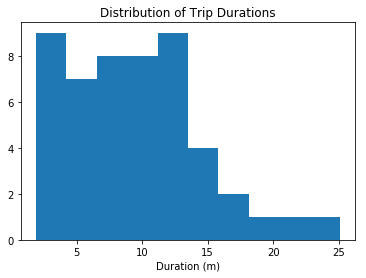

In [22]:
# load library
import matplotlib.pyplot as plt

# this is a 'magic word' that allows for plots to be displayed
# inline with the notebook. If you want to know more, see:
# http://ipython.readthedocs.io/en/stable/interactive/magics.html
%matplotlib inline 

# example histogram, data taken from bay area sample
data = [ 7.65,  8.92,  7.42,  5.50, 16.17,  4.20,  8.98,  9.62, 11.48, 14.33,
        19.02, 21.53,  3.90,  7.97,  2.62,  2.67,  3.08, 14.40, 12.90,  7.83,
        25.12,  8.30,  4.93, 12.43, 10.60,  6.17, 10.88,  4.78, 15.15,  3.53,
         9.43, 13.32, 11.72,  9.85,  5.22, 15.10,  3.95,  3.17,  8.78,  1.88,
         4.55, 12.68, 12.38,  9.78,  7.63,  6.45, 17.38, 11.90, 11.52,  8.63,]
plt.hist(data)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (m)')
plt.show()

In the above cell, we collected fifty trip times in a list, and passed this list as the first argument to the `.hist()` function. This function performs the computations and creates plotting objects for generating a histogram, but the plot is actually not rendered until the `.show()` function is executed. The `.title()` and `.xlabel()` functions provide some labeling for plot context.

You will now use these functions to create a histogram of the trip times for the city you selected in question 4c. Don't separate the Subscribers and Customers for now: just collect all of the trip times and plot them.

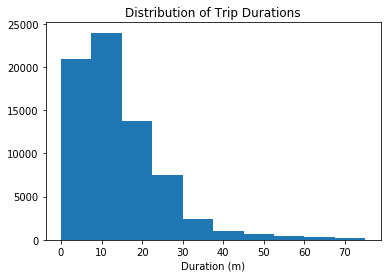

In [23]:
## Use this and additional cells to collect all of the trip times as a list ##
## and then use pyplot functions to generate a histogram of trip times.     ##
def get_durations_list(filename, user_type = None):
    """
    Accumulate duration in one list. If user_type is specified,
    then durations are collected only for that user typer. If 
    the user type is not specified, then the list will contain
    values for all types of users.     
    """
    with open(filename, 'r') as f_in:
        reader = csv.DictReader(f_in)
        durations = []
        for row in reader:   
            # append to list if the user type matches 
            # or if the user type is not specified
            if (row['user_type'] == user_type) or not user_type:
                durations.append(round(float(row['duration']),2))            
    return durations

durations = get_durations_list(city_info["Chicago"]["out_file"])


plt.hist(durations, range=[0,75])
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (m)')
plt.show()

**Question 5**: Use the parameters of the `.hist()` function to plot the distribution of trip times for the Subscribers in your selected city. Do the same thing for only the Customers. Add limits to the plots so that only trips of duration less than 75 minutes are plotted. As a bonus, set the plots up so that bars are in five-minute wide intervals. For each group, where is the peak of each distribution? How would you describe the shape of each distribution?

**Answer**:  
The subscribers distribution looks like right-skewed distribution. The peak is at 5-10 min interval   
The customers distribution also looks like right-skewed distribution. The peak is at 20-25 min interval. But if we set narrower limits (0-40, for exampel), it will look more like normal distribution. 

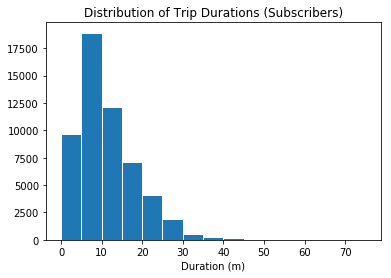

In [24]:
## Use this and additional cells to answer Question 5. ##
subscriber_durations = get_durations_list(city_info["Chicago"]["out_file"], 'Subscriber')
plt.hist(subscriber_durations, range=[0,75], bins=15, edgecolor='white')
plt.title('Distribution of Trip Durations (Subscribers)')
plt.xlabel('Duration (m)')
plt.show()

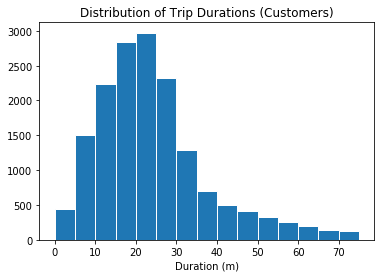

In [25]:
customer_durations = get_durations_list(city_info["Chicago"]["out_file"], 'Customer')
plt.hist(customer_durations, range=[0,75], bins=15, edgecolor='white')
plt.title('Distribution of Trip Durations (Customers)')
plt.xlabel('Duration (m)')
plt.show()

<a id='eda_continued'></a>
## EDA Continued

**Question 6**: Continue the investigation by exploring another question that could be answered by the data available. Document the question you want to explore below. Your investigation should involve at least two variables and should compare at least two groups. You should also use at least one visualization as part of your explorations.

**Answer**:    

I decided to take two questions suggested by the project guide: 

- How does ridership differ by month or season? Which month / season has the highest ridership? Does the ratio of Subscriber trips to Customer trips change depending on the month or season?  
- Is the pattern of ridership different on the weekends versus weekdays? On what days are Subscribers most likely to use the system? What about Customers? Does the average duration of rides change depending on the day of the week?  

**1) How does ridership differ by month or season? Which month / season has the highest ridership? Does the ratio of Subscriber trips to Customer trips change depending on the month or season?**  

The month with highest ridership is September, followed by October and June. It will make sense to explore who are our clients - students, unemployed or employed at the very least. Also, the amount of rides is obviously correlated with the weather. Probably, the period from June to October is the most comfortable for riding a bicycle. We can notice slight decrease in July - one guess is that people are likely to go on vacation in July.

**2) Is the pattern of ridership different on the weekends versus weekdays? On what days are Subscribers most likely to use the system? What about Customers? Does the average duration of rides change depending on the day of the week?**  
Surprisingly, there are significantly fewer rides on weekends compared to weekdays. One guess is that our riders use the bike to get to and from work/school. This complies with our observation in the previous question, where we supposed that in July the decrease can be explained by vacations. 

### Rides by month by user type

In [31]:
def rides_breakdown_by_month(filename):
    """Get rides breakdown by month
    for the specified file. 
    """    
    #generate list for counts
    subscribers_by_month = [0]*12
    customers_by_month = [0]*12
    with open(filename, 'r') as f_in:
        reader = csv.DictReader(f_in)
        for row in reader:   
            if (row['user_type'] == "Subscriber"):
                subscribers_by_month[int(row['month'])-1] += 1
            else:
                customers_by_month[int(row['month'])-1] += 1
    return subscribers_by_month, customers_by_month

In [34]:
def rides_breakdown_by_month_by_city():
    """Get rides breakdown for all cities and 
    accumulate them together. 
    """    
    for city in city_info:
        total_subscribers_by_month = [0]*12
        total_customers_by_month = [0]*12
        subscribers, customers = rides_breakdown_by_month(city_info[city]['out_file'])
        total_subscribers_by_month = [sum(x) for x in zip(total_subscribers_by_month, subscribers)]
        total_customers_by_month = [sum(x) for x in zip(total_customers_by_month, customers)]
    return total_subscribers_by_month, total_customers_by_month
subscribers, customers = rides_breakdown_by_month_by_city()

In [35]:
months = ['January', 'February', 'March', 'April','May', 'June', 
          'July', 'August', 'September', 'October', 'November', 'December']
ind = list(range(1,13))

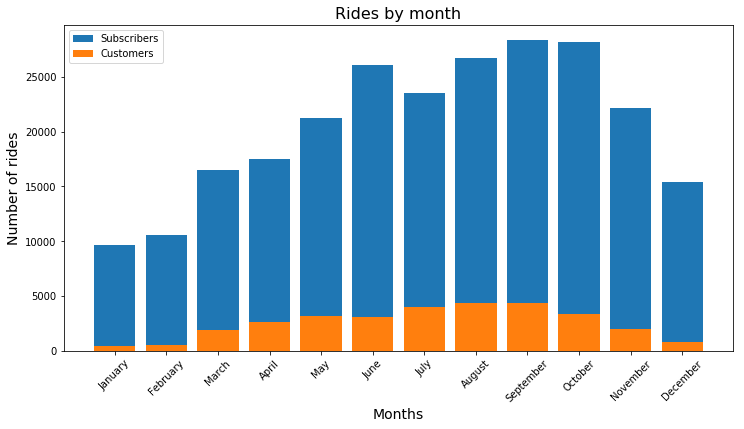

In [36]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
p1 = ax.bar(ind, subscribers, align = 'center')
p2 = ax.bar(ind, customers, align = 'center')
ax.set_xticks(ind)
ax.set_xticklabels(months, rotation=45)
ax.set_title("Rides by month", size=16)
ax.set_xlabel("Months", size=14)
ax.set_ylabel("Number of rides",size=14)
plt.legend((p1[0], p2[0]), ('Subscribers', 'Customers'), loc=2)
plt.show()

### Rides by weekday by user type

In [37]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dict(zip(weekdays, [0]*7))
def rides_breakdown_by_weekday(filename):
    """Get rides breakdown by the day of week 
    for the specified file. 
    """
    #generate list for counts
    subscribers_by_weekday = dict(zip(weekdays, [0]*7))
    customers_by_weekday = dict(zip(weekdays, [0]*7))
    with open(filename, 'r') as f_in:
        reader = csv.DictReader(f_in)
        for row in reader:   
            if (row['user_type'] == "Subscriber"):
                subscribers_by_weekday[row['day_of_week']] += 1
            else:
                customers_by_weekday[row['day_of_week']] += 1
    subscribers_by_weekday = list(zip(*list(subscribers_by_weekday.items())))[1]
    customers_by_weekday = list(zip(*list(customers_by_weekday.items())))[1]
    return subscribers_by_weekday, customers_by_weekday

In [38]:
def rides_breakdown_by_weekday_by_city():
    """Get rides breakdown for all cities and 
    accumulate them together. 
    """
    for city in city_info:
        total_subscribers_by_weekday = [0]*7
        total_customers_by_weekday = [0]*7
        subscribers, customers = rides_breakdown_by_weekday(city_info[city]['out_file'])
        total_subscribers_by_weekday = [sum(x) for x in zip(total_subscribers_by_weekday, subscribers)]
        total_customers_by_weekday = [sum(x) for x in zip(total_customers_by_weekday, customers)]
    return total_subscribers_by_weekday, total_customers_by_weekday
    

In [39]:
subscribers_by_weekday, customers_by_weekday = rides_breakdown_by_weekday_by_city()

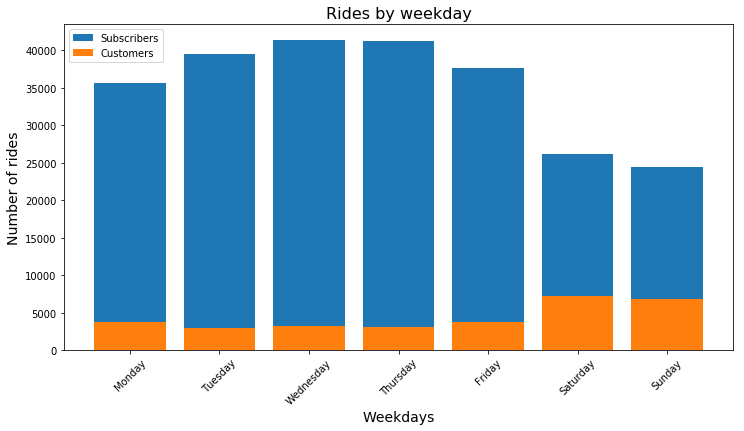

In [40]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
p1 = ax.bar(range(1,8), subscribers_by_weekday, align = 'center')
p2 = ax.bar(range(1,8), customers_by_weekday, align = 'center')
ax.set_xticks(range(1,8))
ax.set_xticklabels(weekdays, rotation=45)
ax.set_title("Rides by weekday", size=16)
ax.set_xlabel("Weekdays", size=14)
ax.set_ylabel("Number of rides",size=14)
plt.legend((p1[0], p2[0]), ('Subscribers', 'Customers'), loc=2)
plt.show()

<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! This is only a sampling of the data analysis process: from generating questions, wrangling the data, and to exploring the data. Normally, at this point in the data analysis process, you might want to draw conclusions about the data by performing a statistical test or fitting the data to a model for making predictions. There are also a lot of potential analyses that could be performed on the data which are not possible with only the data provided. For example, detailed location data has not been investigated. Where are the most commonly used docks? What are the most common routes? As another example, weather has potential to have a large impact on daily ridership. How much is ridership impacted when there is rain or snow? Are subscribers or customers affected more by changes in weather?

**Question 7**: Putting the bike share data aside, think of a topic or field of interest where you would like to be able to apply the techniques of data science. What would you like to be able to learn from your chosen subject?

**Answer**: 

I am intersted in analysing human behaviour. For example, there is a website mytvshows.me where people record everything they've watched - it would be interesting to explore that data. It would have been even better if it was possible to connect data from social profiles for these users. 

<b>References</b>  
<ul>
<li><a href="https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html">Stacked bar plot (Matplotlib)</a></li>
<li><a href="https://stackoverflow.com/questions/209840/convert-two-lists-into-a-dictionary-in-python#209854">Convert two lists into a dictionary in Python (StackOverflow)</a></li>
</ul>   

In [41]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Bike_Share_Analysis.ipynb'])

0